<a href="https://colab.research.google.com/github/SaatvikK/Tweet-Emotion-Recognition/blob/main/Tweet_Emotion_Recognition_Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import datasets
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.15.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [2]:
ds = datasets.load_dataset("dair-ai/emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
trainingDS = ds['train']
def getTweets(data):
  return [x['text'] for x in data], [x['label'] for x in data]

trainingDS

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

## Task 4: Tokenizer

1. Tokenizing the tweets

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

# What is a tokenizer?
# The data set contains sentences and words. To train a model,
# these words have to be mapped to a unique number.
# This is what tokenization accomplishes.
# It identifies all unique words in the set, and maps them to a
# unique number.


In [13]:
# OOV = Out Of Vocab token. This is the token that is assigned to all words
# deemed unimportant for classification.
# We assign these words a token of <UNK>.
# `num_words` is the most common 10k words.
tokenizer = Tokenizer(num_words=10000, oov_token="<UNK>")
tweets, labels = getTweets(trainingDS)
tokenizer.fit_on_texts(tweets)

In [7]:
# prints tokenized version of a specficic string
print(tweets[0])
tokenizer.texts_to_sequences([tweets[0]])

i didnt feel humiliated


[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

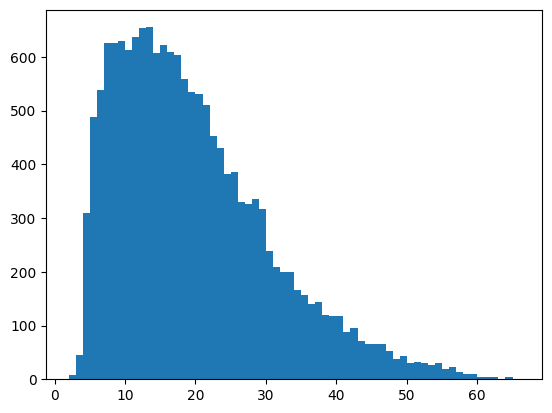

In [8]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [9]:
maxlen = 50

# We pad every tweet less than 50 words with 0's,
# so that the dataset is uniform.
from tensorflow.keras.preprocessing.sequence import pad_sequences
def getSequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = 50)
  return padded


In [10]:
paddedTrain = getSequences(tokenizer, tweets)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [11]:
classes = set(labels)
classes
#sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

{0, 1, 2, 3, 4, 5}

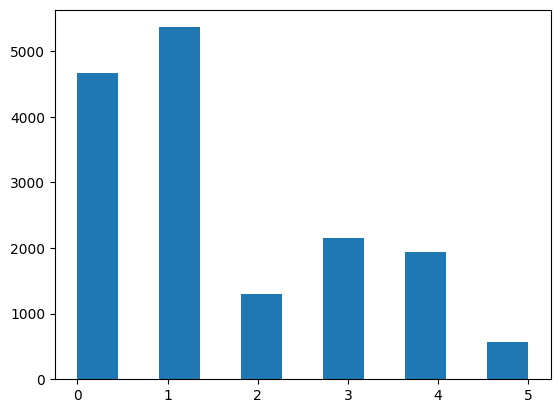

In [14]:
# see the frequency of each label in the training
plt.hist(labels, bins = 11)
plt.show()

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirection  (None, 50, 40)            5920      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175926 (687.21 KB)
Trainable params: 175926 (687.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set